### Import libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import time
from pathlib import Path
from scipy import ndimage, fft
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, precision_recall_curve, average_precision_score
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.utils import shuffle


## Data Preprocessor

In [2]:


class LightFluxProcessor:

    def __init__(self, fourier=True, normalize=True, gaussian=True, standardize=True):
        self.fourier = fourier
        self.normalize = normalize
        self.gaussian = gaussian
        self.standardize = standardize

    def fourier_transform(self, X):
        return np.abs(np.fft.fft(X, n=X.size))

    def process(self, df_train_x, df_dev_x):
        # Apply fourier transform
        if self.fourier:
            print("Applying Fourier...")
            df_train_x = np.apply_along_axis(self.fourier_transform, axis=1, arr=df_train_x)
            df_dev_x = np.apply_along_axis(self.fourier_transform, axis=1, arr=df_dev_x)

            # Keep the first half of data as it is symmetrical after the previous steps
            df_train_x = df_train_x[:, :(df_train_x.shape[1] // 2)]
            df_dev_x = df_dev_x[:, :(df_dev_x.shape[1] // 2)]

        # Normalize
        if self.normalize:
            print("Normalizing...")
            df_train_x = normalize(df_train_x)
            df_dev_x = normalize(df_dev_x)

        # Gaussian filter to smooth out data
        if self.gaussian:
            print("Applying Gaussian Filter...")
            df_train_x = ndimage.filters.gaussian_filter(df_train_x, sigma=10)
            df_dev_x = ndimage.filters.gaussian_filter(df_dev_x, sigma=10)

        if self.standardize:
            # Standardize X data
            print("Standardizing...")
            std_scaler = StandardScaler()
            df_train_x = std_scaler.fit_transform(df_train_x)
            df_dev_x = std_scaler.transform(df_dev_x)

        print("Finished Processing!")
        return df_train_x, df_dev_x




### Load datasets

In [3]:
train_dataset_path = "Data/exoTrain.csv"
dev_dataset_path = "Data/exoTest.csv"

print("Loading datasets...")
df_train = pd.read_csv(train_dataset_path, encoding = "ISO-8859-1")
df_dev = pd.read_csv(dev_dataset_path, encoding = "ISO-8859-1")
print("Loaded datasets!")

# Generate X and Y dataframe sets
df_train_x = df_train.drop('LABEL', axis=1)
df_dev_x = df_dev.drop('LABEL', axis=1)
df_train_y = df_train.LABEL
df_dev_y = df_dev.LABEL

Loading datasets...
Loaded datasets!


### Process data and create numpy matrices

In [4]:
def np_X_Y_from_df(df):
    df = shuffle(df)
    df_X = df.drop(['LABEL'], axis=1)
    X = np.array(df_X)
    Y_raw = np.array(df['LABEL']).reshape((len(df['LABEL']),1))
    Y = Y_raw == 2
    return X, Y

In [5]:
# Process dataset
LFP = LightFluxProcessor(
    fourier=True,
    normalize=False,
    gaussian=False,
    standardize=False)
df_train_x, df_dev_x = LFP.process(df_train_x, df_dev_x)

# Rejoin X and Y
df_train_processed = pd.DataFrame(df_train_x).join(pd.DataFrame(df_train_y))
df_dev_processed = pd.DataFrame(df_dev_x).join(pd.DataFrame(df_dev_y))

# Load X and Y numpy arrays
X_train, Y_train = np_X_Y_from_df(df_train_processed)
X_dev, Y_dev = np_X_Y_from_df(df_dev_processed)

Applying Fourier...
Finished Processing!


### Describe datasets

In [6]:
(num_examples, n_x) = X_train.shape # (n_x: input size, m : number of examples in the train set)
n_y = Y_train.shape[1] # n_y : output size
print("X_train.shape: ", X_train.shape)
print("Y_train.shape: ", Y_train.shape)
print("X_dev.shape: ", X_dev.shape)
print("Y_dev.shape: ", Y_dev.shape)
print("n_x: ", n_x)
print("num_examples: ", num_examples)
print("n_y: ", n_y)

X_train.shape:  (5087, 1598)
Y_train.shape:  (5087, 1)
X_dev.shape:  (570, 1598)
Y_dev.shape:  (570, 1)
n_x:  1598
num_examples:  5087
n_y:  1


## Build Model, Train, and Predict

In [7]:
model = LinearSVC()

# sm = SMOTE(ratio = 1.0)
# X_train_sm, Y_train_sm = sm.fit_sample(X_train, Y_train)
X_train_sm, Y_train_sm = X_train, Y_train

# Train
print("Training...")
model.fit(X_train_sm, Y_train_sm)

train_outputs = model.predict(X_train_sm)
dev_outputs = model.predict(X_dev)
print("Finished Training!")

Training...


C:\Users\vikas\Desktop\exoplanet\env\lib\site-packages\sklearn\utils\validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\vikas\Desktop\exoplanet\env\lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


Finished Training!


C:\Users\vikas\Desktop\exoplanet\env\lib\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


## Calculate and Display Metrics

In [8]:
# Metrics
train_outputs = model.predict(X_train_sm)
dev_outputs = model.predict(X_dev)
train_outputs = np.rint(train_outputs)
dev_outputs = np.rint(dev_outputs)
accuracy_train = accuracy_score(Y_train_sm, train_outputs)
accuracy_dev = accuracy_score(Y_dev, dev_outputs)
precision_train = precision_score(Y_train_sm, train_outputs)
precision_dev = precision_score(Y_dev, dev_outputs)
recall_train = recall_score(Y_train_sm, train_outputs)
recall_dev = recall_score(Y_dev, dev_outputs)
confusion_matrix_train = confusion_matrix(Y_train_sm, train_outputs)
confusion_matrix_dev = confusion_matrix(Y_dev, dev_outputs)
classification_report_train = classification_report(Y_train_sm, train_outputs)
classification_report_dev = classification_report(Y_dev, dev_outputs)

print(" ")
print(" ")
print("Train Set Error", 1.0 - accuracy_train)
print("Dev Set Error", 1.0 - accuracy_dev)
print("------------")
print("Precision - Train Set", precision_train)
print("Precision - Dev Set", precision_dev)
print("------------")
print("Recall - Train Set", recall_train)
print("Recall - Dev Set", recall_dev)
print("------------")
print("Confusion Matrix - Train Set")
print(confusion_matrix_train)
print("Confusion Matrix - Dev Set")
print(confusion_matrix_dev)
print("------------")
print(" ")
print(" ")
print("------------")
print("classification_report_train")
print(classification_report_train)
print("classification_report_dev")
print(classification_report_dev)

 
 
Train Set Error 0.0027521132298014006
Dev Set Error 0.010526315789473717
------------
Precision - Train Set 0.7254901960784313
Precision - Dev Set 0.42857142857142855
------------
Recall - Train Set 1.0
Recall - Dev Set 0.6
------------
Confusion Matrix - Train Set
[[5036   14]
 [   0   37]]
Confusion Matrix - Dev Set
[[561   4]
 [  2   3]]
------------
 
 
------------
classification_report_train
              precision    recall  f1-score   support

       False       1.00      1.00      1.00      5050
        True       0.73      1.00      0.84        37

    accuracy                           1.00      5087
   macro avg       0.86      1.00      0.92      5087
weighted avg       1.00      1.00      1.00      5087

classification_report_dev
              precision    recall  f1-score   support

       False       1.00      0.99      0.99       565
        True       0.43      0.60      0.50         5

    accuracy                           0.99       570
   macro avg       0.71 

AUC training set: 0.542
AUC dev set: 0.237
Accuracy training set: 0.997
Accuracy dev set: 0.989
Precision training set: 0.725
Precision dev set: 0.429
Recall training set: 1.000
Recall dev set: 0.600
 


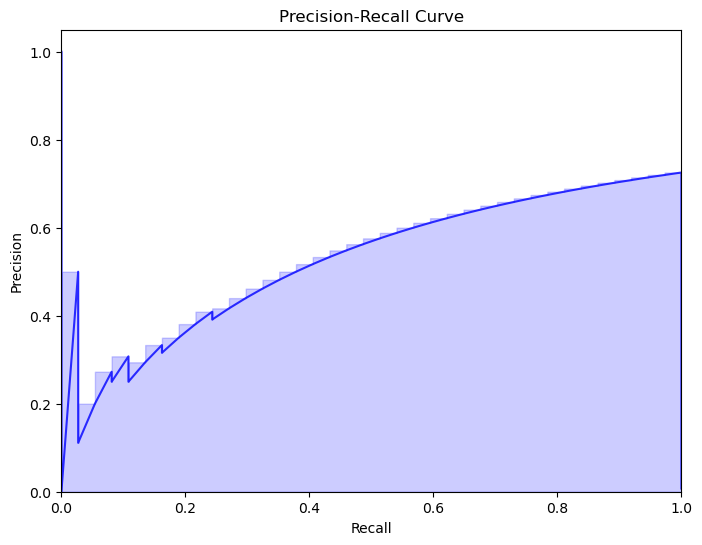

Confusion Matrix - Train Set
[[5036   14]
 [   0   37]]
Confusion Matrix - Dev Set
[[561   4]
 [  2   3]]


In [9]:


# Metrics
train_prob = model.decision_function(X_train)  # Use decision_function for linear SVM
dev_prob = model.decision_function(X_dev)

# Calculate binary predictions (0 or 1) based on the decision function
train_outputs = (train_prob > 0).astype(int)
dev_outputs = (dev_prob > 0).astype(int)

accuracy_train = accuracy_score(Y_train_sm, train_outputs)
accuracy_dev = accuracy_score(Y_dev, dev_outputs)
precision_train = precision_score(Y_train_sm, train_outputs)
precision_dev = precision_score(Y_dev, dev_outputs)
recall_train = recall_score(Y_train_sm, train_outputs)
recall_dev = recall_score(Y_dev, dev_outputs)
confusion_matrix_train = confusion_matrix(Y_train_sm, train_outputs)
confusion_matrix_dev = confusion_matrix(Y_dev, dev_outputs)
classification_report_train = classification_report(Y_train_sm, train_outputs)
classification_report_dev = classification_report(Y_dev, dev_outputs)

# Calculate AUC scores
ap_train = average_precision_score(Y_train_sm, train_prob)
ap_dev = average_precision_score(Y_dev, dev_prob)

# Display metrics
print("AUC training set: %.3f" % ap_train)
print("AUC dev set: %.3f" % ap_dev)
print("Accuracy training set: %.3f" % accuracy_train)
print("Accuracy dev set: %.3f" % accuracy_dev)
print("Precision training set: %.3f" % precision_train)
print("Precision dev set: %.3f" % precision_dev)
print("Recall training set: %.3f" % recall_train)
print("Recall dev set: %.3f" % recall_dev)
print(" ")

# Precision-Recall Curve
precision, recall, thresholds = precision_recall_curve(Y_train_sm, train_prob)
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='b', alpha=0.8)
plt.fill_between(recall, precision, alpha=0.2, color='b', step='post')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall Curve')
plt.show()

# Confusion matrices
print("Confusion Matrix - Train Set")
print(confusion_matrix_train)
print("Confusion Matrix - Dev Set")
print(confusion_matrix_dev)
